# Import Libraries

In [1]:
import numpy as np
import cv2
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
# Import different classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

# Interface Declarations

## Data Loading Logic

In [15]:
class FruitQualityDataLoader:
    def __init__(self):
        self.quality_mappings = {
            'fresh': 0, 'good': 0,
            'mild': 1, 'mixed': 1,
            'rotten': 2, 'bad': 2
        }
        self.quality_labels = ['Good/Fresh', 'Mild/Mixed', 'Rotten/Bad']
        
    def load_zenodo_dataset(self, base_path, subset="FruQ-DB"):
        """Load Zenodo dataset"""
        base_path = Path(base_path)
        image_paths = []
        labels = []
        
        if subset == "FruQ-DB":
            dataset_path = base_path / "FruQ-DB"
            if not dataset_path.exists():
                raise ValueError(f"FruQ-DB not found at {dataset_path}")
            
            # Process quality folders directly
            quality_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
            
            for folder in quality_folders:
                if folder.name.lower() in self.quality_mappings:
                    label = self.quality_mappings[folder.name.lower()]
                    print(f"Processing {folder.name}...")
                    
                    for img_path in folder.glob('*.[jp][pn][g]'):
                        image_paths.append(str(img_path))
                        labels.append(label)
        
        elif subset == "FruQ-multi":
            dataset_path = base_path / "FruQ-multi"
            fruit_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
            
            for fruit_folder in fruit_folders:
                print(f"Processing fruit: {fruit_folder.name}")
                quality_folders = [f for f in fruit_folder.iterdir() if f.is_dir()]
                
                for folder in quality_folders:
                    if folder.name.lower() in self.quality_mappings:
                        label = self.quality_mappings[folder.name.lower()]
                        print(f"Processing quality: {folder.name}...")
                        
                        for img_path in folder.glob('*.[jp][pn][g]'):
                            image_paths.append(str(img_path))
                            labels.append(label)
                            
        return self._summarize_and_return(image_paths, labels)

    def load_kaggle_dataset(self, base_path):
        """
        Load Kaggle dataset with the following structure:
        - Bad Quality_Fruits/
            - Apple_Bad/
            - Banana_Bad/
            etc.
        - Good Quality_Fruits/
            - Apple_Good/
            - Banana_Good/
            etc.
        - Mixed Quality_Fruits/
            - Apple/
            - Banana/
            etc.
        """
        base_path = Path(base_path)
        image_paths = []
        labels = []
        
        # Define quality directories and their corresponding labels
        quality_dirs = {
            'Bad Quality_Fruits': 2,    # maps to 'bad'/'rotten'
            'Good Quality_Fruits': 0,   # maps to 'good'/'fresh'
            'Mixed Qualit_Fruits': 1    # maps to 'mixed'/'mild'
        }
        
        # Process each quality directory
        for quality_dir, label in quality_dirs.items():
            quality_path = base_path / quality_dir
            if not quality_path.exists():
                print(f"Warning: {quality_dir} not found at {quality_path}")
                continue
                
            print(f"\nProcessing {quality_dir}...")
            
            # Get all fruit subdirectories
            fruit_dirs = [f for f in quality_path.iterdir() if f.is_dir()]
            
            # Process each fruit directory
            for fruit_dir in fruit_dirs:
                print(f"Processing {fruit_dir.name}...")
                
                # Handle both .jpg and .png files
                for img_path in fruit_dir.glob('*.[jp][pn][g]'):
                    image_paths.append(str(img_path))
                    labels.append(label)
        
        return self._summarize_and_return(image_paths, labels)
    
    def _summarize_and_return(self, image_paths, labels):
        """Helper method to summarize dataset statistics and return results"""
        print(f"\nDataset Statistics:")
        unique, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return image_paths, np.array(labels)
    
    def load_combined_datasets(self, kaggle_path, zenodo_path, zenodo_subset="FruQ-DB"):
        """
        Load and combine both Kaggle and Zenodo datasets
        """
        # Load Kaggle dataset
        kaggle_paths, kaggle_labels = self.load_kaggle_dataset(kaggle_path)
        
        # Load Zenodo dataset
        zenodo_paths, zenodo_labels = self.load_zenodo_dataset(zenodo_path, zenodo_subset)
        
        # Combine datasets
        combined_paths = kaggle_paths + zenodo_paths
        combined_labels = np.concatenate([kaggle_labels, zenodo_labels])
        
        print("\nCombined Dataset Statistics:")
        unique, counts = np.unique(combined_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"{self.quality_labels[label]}: {count} images")
            
        return combined_paths, combined_labels

## Feature Extractor Logic

In [4]:
class FruitFeatureExtractor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.scaler = StandardScaler()
        
    def extract_features(self, img_path):
        """Extract color features from image"""
        # Read and resize image
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, self.target_size)
        
        # Convert to different color spaces
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        features = []
        
        # Extract features from each color space
        for color_img in [img, hsv_img, lab_img]:
            for channel in cv2.split(color_img):
                features.extend([
                    np.mean(channel),
                    np.std(channel),
                    np.percentile(channel, 25),
                    np.percentile(channel, 75)
                ])
        
        return np.array(features)
    
    def prepare_dataset(self, image_paths, fit_scaler=True):
        """Extract features from all images and scale them"""
        features = []
        for i, img_path in enumerate(image_paths):
            if i % 100 == 0:
                print(f"Processing image {i}/{len(image_paths)}", end='\r')
            features.append(self.extract_features(img_path))
        
        features = np.array(features)
        
        if fit_scaler:
            features = self.scaler.fit_transform(features)
        else:
            features = self.scaler.transform(features)
            
        print("\nFeature extraction completed!")
        return features

## Model Evaluator Logic

In [5]:
class ModelEvaluator:
    def __init__(self, quality_labels=['Fresh', 'Mild', 'Rotten']):
        self.quality_labels = quality_labels
    
    def evaluate_model(self, y_true, y_pred, model_name="Model"):
        """Evaluate model performance with metrics and visualization"""
        print(f"\n{model_name} Performance:")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.quality_labels))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.quality_labels,
                   yticklabels=self.quality_labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Test Classification with Baseline Models

In [6]:
# Cell 2: Baseline Classifiers
class RandomClassifier(BaseEstimator, ClassifierMixin):
    """Classifier that predicts randomly based on training class distribution"""
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.class_probs_ = np.bincount(y) / len(y)
        return self
        
    def predict(self, X):
        return np.random.choice(self.classes_, size=len(X), p=self.class_probs_)

class MajorityClassifier(BaseEstimator, ClassifierMixin):
    """Classifier that always predicts the most common class from training"""
    def fit(self, X, y):
        self.majority_class_ = np.bincount(y).argmax()
        return self
        
    def predict(self, X):
        return np.full(len(X), self.majority_class_)

In [7]:
def extract_basic_features(img_path):
    """Extract only mean RGB values as features"""
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (224, 224))
    mean_rgb = np.mean(img, axis=(0,1))  # Just mean of each channel
    return mean_rgb

In [8]:
def run_baseline_tests(train_paths, train_labels, test_paths, test_labels):
    # 1. Try random classifier
    print("\nRandom Classifier (based on class distribution):")
    rand_clf = RandomClassifier()
    rand_clf.fit(None, train_labels)
    rand_pred = rand_clf.predict(test_labels)
    print(classification_report(test_labels, rand_pred))
    
    # 2. Try majority classifier
    print("\nMajority Classifier:")
    maj_clf = MajorityClassifier()
    maj_clf.fit(None, train_labels)
    maj_pred = maj_clf.predict(test_labels)
    print(classification_report(test_labels, maj_pred))

In [16]:
loader = FruitQualityDataLoader()
image_paths, labels = loader.load_zenodo_dataset('fruit_datasets/zenodo_data', subset="FruQ-DB")
print(len(image_paths))

# Split data
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Run baseline tests
run_baseline_tests(train_paths, train_labels, test_paths, test_labels)

Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images
5647

Random Classifier (based on class distribution):
              precision    recall  f1-score   support

           0       0.41      0.41      0.41       437
           1       0.26      0.27      0.26       273
           2       0.41      0.40      0.41       420

    accuracy                           0.37      1130
   macro avg       0.36      0.36      0.36      1130
weighted avg       0.37      0.37      0.37      1130


Majority Classifier:
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       437
           1       0.00      0.00      0.00       273
           2       0.00      0.00      0.00       420

    accuracy                           0.39      1130
   macro avg       0.13      0.33      0.19      1130
weighted avg       0.15      0.39      0.22      1130



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Check to see if there is data leakage

In [10]:
def check_path_overlap(train_paths, test_paths):
   train_set = set(train_paths)
   test_set = set(test_paths)
   
   overlap = train_set.intersection(test_set)
   
   if overlap:
       print(f"Found {len(overlap)} overlapping paths")
       print("Sample overlaps:")
       for path in list(overlap)[:5]:
           print(path)
       return True
   else:
       print("No overlapping paths found")
       return False

In [11]:
has_overlap = check_path_overlap(train_paths, test_paths)

No overlapping paths found


## KNN with reduced feature set

In [12]:
print("\nKNN with basic RGB means only:")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Extract basic features
print("Extracting basic features...")
train_features = np.array([extract_basic_features(path) for path in train_paths])
test_features = np.array([extract_basic_features(path) for path in test_paths])

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Train and evaluate
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features_scaled, train_labels)
basic_pred = knn.predict(test_features_scaled)
print(classification_report(test_labels, basic_pred))


KNN with basic RGB means only:
Extracting basic features...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      0.99      1.00       273
           2       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



# Test Classification with ML Models

In [13]:
# Initialize loader and extractor
loader = FruitQualityDataLoader()
extractor = FruitFeatureExtractor()

# Load dataset
image_paths, labels = loader.load_zenodo_dataset('fruit_datasets/zenodo_data', subset="FruQ-DB")

# Split data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Extract features
print("Extracting training features...")
X_train = extractor.prepare_dataset(train_paths, fit_scaler=True)
print("Extracting test features...")
X_test = extractor.prepare_dataset(test_paths, fit_scaler=False)

Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images
Extracting training features...
Processing image 4500/4517
Feature extraction completed!
Extracting test features...
Processing image 1100/1130
Feature extraction completed!


In [14]:
has_overlap = check_path_overlap(train_paths, test_paths)

No overlapping paths found



Training KNN...
Evaluating KNN...

KNN Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       437
        Mild       1.00      1.00      1.00       273
      Rotten       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



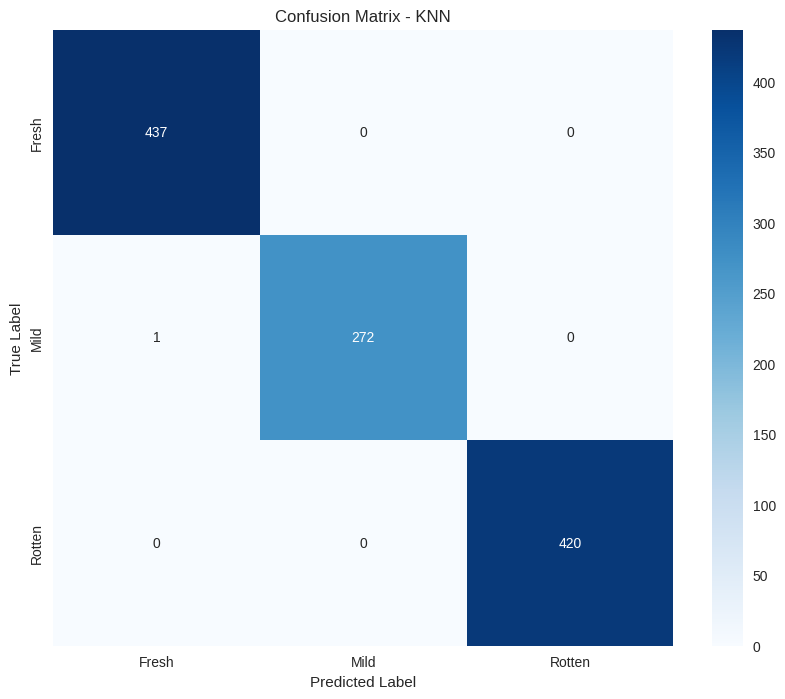


Training SVM...
Evaluating SVM...

SVM Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.94      1.00      0.97       437
        Mild       0.99      0.89      0.94       273
      Rotten       1.00      1.00      1.00       420

    accuracy                           0.97      1130
   macro avg       0.98      0.96      0.97      1130
weighted avg       0.97      0.97      0.97      1130



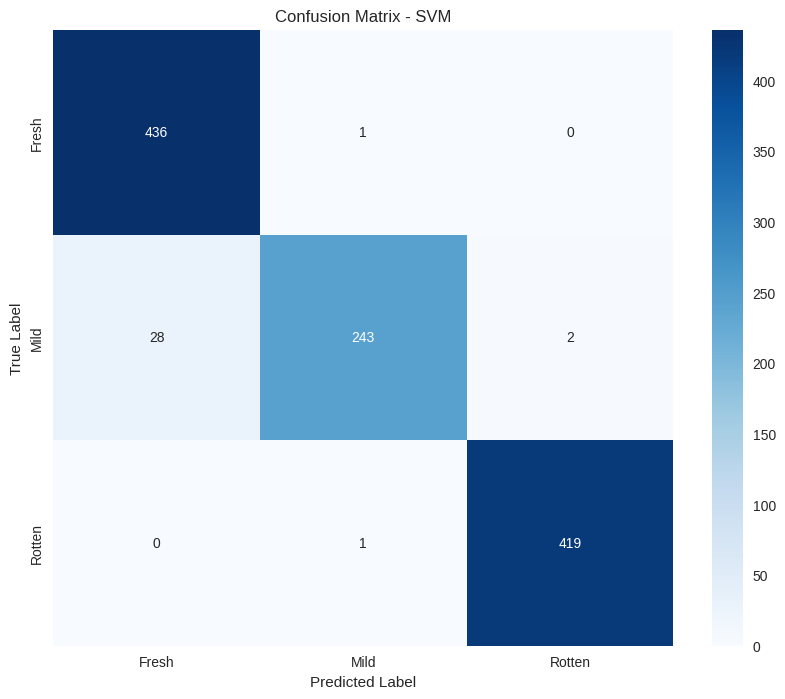


Training Random Forest...
Evaluating Random Forest...

Random Forest Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       437
        Mild       1.00      0.99      1.00       273
      Rotten       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



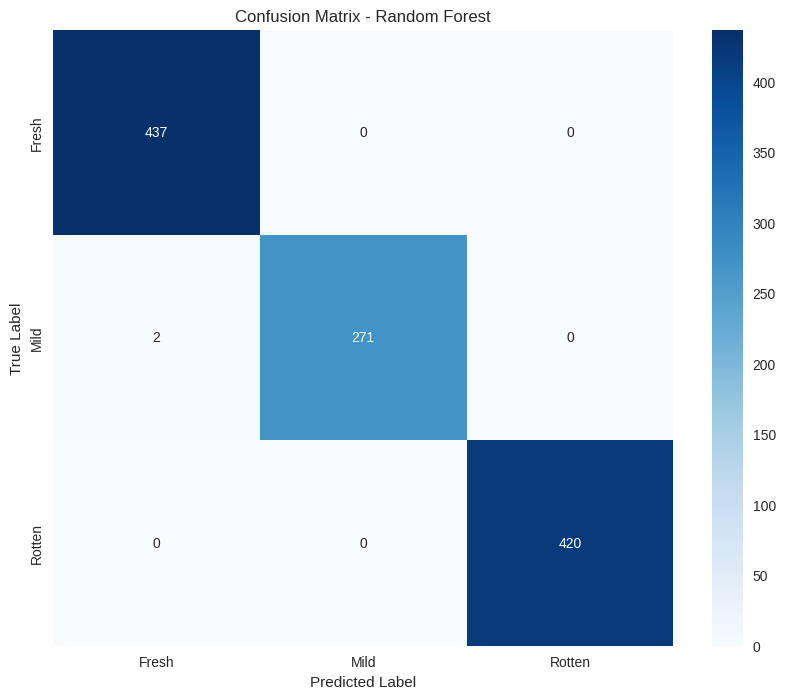


Training Neural Network...
Evaluating Neural Network...

Neural Network Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       437
        Mild       1.00      0.99      0.99       273
      Rotten       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



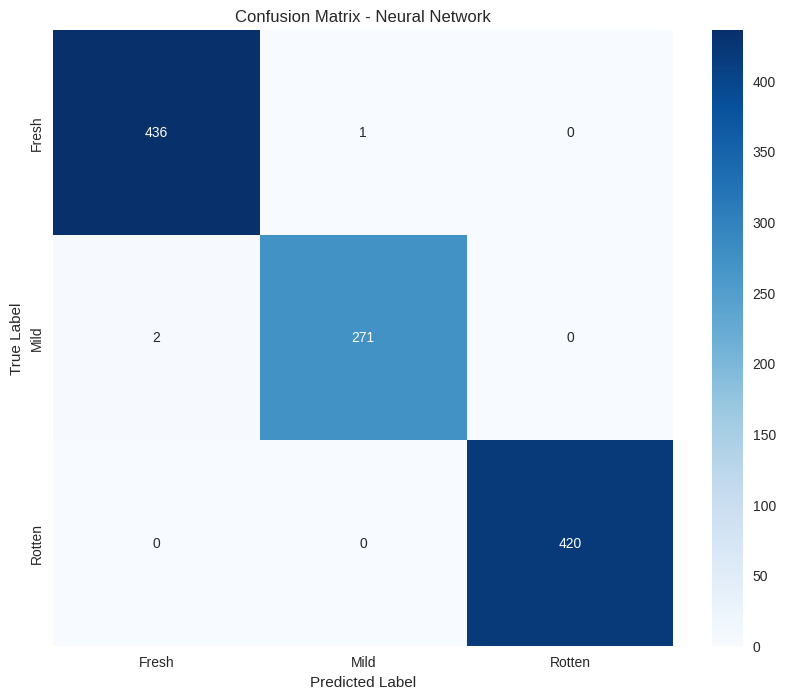


Training Decision Tree...
Evaluating Decision Tree...

Decision Tree Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       437
        Mild       1.00      0.99      1.00       273
      Rotten       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



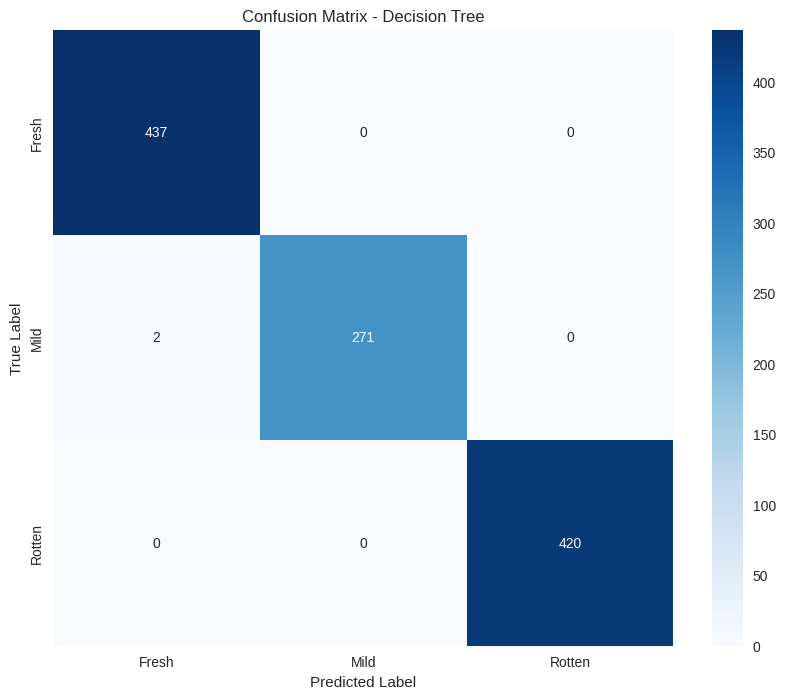

In [16]:
# Initialize evaluator
evaluator = ModelEvaluator()

# Dictionary of classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50)),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, train_labels)
    
    print(f"Evaluating {name}...")
    predictions = clf.predict(X_test)
    evaluator.evaluate_model(test_labels, predictions, name)

# Test Regression Model

## Regressor Logic

In [23]:
class FruitQualityRegressor:
    def __init__(self, n_anchor_samples=3, target_size=(224, 224)):
        """
        Initialize the fruit quality regression system.
        
        Parameters:
        -----------
        n_anchor_samples : int
            Number of samples to take from each end of the spectrum (fresh and rotten)
        target_size : tuple
            Image size for feature extraction
        """
        self.n_anchor_samples = n_anchor_samples
        self.feature_extractor = FruitFeatureExtractor(target_size=target_size)
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1
        )
        
    def get_anchor_examples(self, fruit_dir):
        """Get anchor examples from fresh and rotten folders."""
        fruit_dir = Path(fruit_dir)
        
        # Handle different naming conventions
        good_dir = fruit_dir / 'Good' if (fruit_dir / 'Good').exists() else fruit_dir / 'Fresh'
        rotten_dir = fruit_dir / 'Rotten'
        
        # Get and sort images
        good_images = sorted(list(good_dir.glob('*.[jp][pn][g]')))
        rotten_images = sorted(list(rotten_dir.glob('*.[jp][pn][g]')))
        
        if not good_images or not rotten_images:
            return [], []
        
        # Take first n_samples from fresh and last n_samples from rotten
        fresh_anchors = good_images[:self.n_anchor_samples]
        rotten_anchors = rotten_images[-self.n_anchor_samples:]
        
        # Combine paths and create corresponding scores
        anchor_paths = fresh_anchors + rotten_anchors
        anchor_scores = np.array([1.0] * len(fresh_anchors) + [0.0] * len(rotten_anchors))
        
        return [str(p) for p in anchor_paths], anchor_scores
    
    def get_all_non_anchor_images(self, fruit_dir, anchor_paths):
        """Get all images except anchor examples."""
        fruit_dir = Path(fruit_dir)
        
        good_dir = fruit_dir / 'Good' if (fruit_dir / 'Good').exists() else fruit_dir / 'Fresh'
        mild_dir = fruit_dir / 'Mild' if (fruit_dir / 'Mild').exists() else fruit_dir / 'mild'
        rotten_dir = fruit_dir / 'Rotten'
        
        all_paths = []
        for directory in [good_dir, mild_dir, rotten_dir]:
            if directory.exists():
                all_paths.extend(sorted(directory.glob('*.[jp][pn][g]')))
        
        # Convert to sets for efficient removal of anchor paths
        all_paths_set = set(str(p) for p in all_paths)
        anchor_paths_set = set(anchor_paths)
        
        # Return only non-anchor paths
        return sorted(list(all_paths_set - anchor_paths_set))
    
    def process_all_fruits(self, base_dir):
        """
        Process all fruit directories and collect examples.
        
        Parameters:
        -----------
        base_dir : str or Path
            Base directory containing all fruit subdirectories
        
        Returns:
        --------
        anchor_paths : list
            Paths to anchor images (freshest and most rotten)
        anchor_scores : numpy.array
            Scores for anchor images (1 for fresh, 0 for rotten)
        non_anchor_paths : list
            Paths to all non-anchor images for prediction
        fruit_labels : list
            Fruit type labels corresponding to anchor images
        """
        base_dir = Path(base_dir)
        fruit_dirs = list(base_dir.glob('*Q')) + list(base_dir.glob('*DB'))
        
        anchor_paths = []
        anchor_scores = []
        non_anchor_paths = []
        fruit_labels = []
        
        for fruit_dir in fruit_dirs:
            fruit_name = fruit_dir.name.replace('Q', '').replace('DB', '')
            print(f"Processing {fruit_name}...")
            
            # Get anchor examples first
            paths, scores = self.get_anchor_examples(fruit_dir)
            anchor_paths.extend(paths)
            anchor_scores.extend(scores)
            fruit_labels.extend([fruit_name] * len(paths))
            
            # Get non-anchor images
            non_anchor = self.get_all_non_anchor_images(fruit_dir, paths)
            non_anchor_paths.extend(non_anchor)
        
        return anchor_paths, np.array(anchor_scores), non_anchor_paths, fruit_labels
    
    def train(self, base_dir):
        """
        Train the regression model using anchor examples.
        
        Parameters:
        -----------
        base_dir : str
            Base directory containing all fruit subdirectories
            
        Returns:
        --------
        non_anchor_paths : list
            Paths to images for prediction
        """
        print("Collecting anchor examples...")
        anchor_paths, anchor_scores, non_anchor_paths, fruit_labels = self.process_all_fruits(base_dir)
        
        print("Extracting features from anchor examples...")
        X_anchors = self.feature_extractor.prepare_dataset(anchor_paths, fit_scaler=True)
        
        print("Training regression model...")
        self.model.fit(X_anchors, anchor_scores)
        print("Training completed!")
        
        return non_anchor_paths
    
    def predict(self, image_paths):
        """
        Predict quality scores for new images.
        
        Parameters:
        -----------
        image_paths : str or list
            Single image path or list of image paths
            
        Returns:
        --------
        predictions : float or array
            Predicted quality scores between 0 and 1
        categories : str or list
            Categorical interpretation of scores
        """
        # Handle single image path
        single_image = isinstance(image_paths, (str, Path))
        if single_image:
            image_paths = [image_paths]
        
        # Extract features
        X = self.feature_extractor.prepare_dataset(image_paths, fit_scaler=False)
        
        
        # Make predictions
        predictions = self.model.predict(X)
        predictions = np.clip(predictions, 0, 1)
        
        # Convert scores to categories (for reference)
        categories = []
        for score in predictions:
            if score >= 0.8:
                categories.append('Fresh')
            elif score >= 0.3:
                categories.append('Mild')
            else:
                categories.append('Rotten')
                # Return single value if single image was provided
        if single_image:
            return predictions[0], categories[0]
            
        return predictions, categories

In [24]:
regressor = FruitQualityRegressor(n_anchor_samples=100)

# Train the model
base_dir = "fruit_datasets/zenodo_data/FruQ-multi"
non_anchor_paths = regressor.train(base_dir)


Processing Cucumber...
Processing Grape...
Processing Kaki...
Processing Papaya...
Processing Peach...
Processing Pear...
Processing Pepper...
Processing Strawberry...
Processing tomato...
Processing Watermelo...
Processing Banana...
Extracting features from anchor examples...
Processing image 1800/1899
Feature extraction completed!
Training regression model...
Training completed!


In [20]:
# Single image prediction
score, category = regressor.predict("fruit_datasets/zenodo_data/FruQ-multi/WatermeloQ/Rotten/Image501.png")
print(f"Quality score: {score:.3f}")
print(f"Category: {category}")

Processing image 0/1
Feature extraction completed!
Quality score: 0.000
Category: Rotten


# Test Across Data Sets

Loading Zenodo dataset...
Processing Fresh...
Processing Mild...
Processing Rotten...

Dataset Statistics:
Good/Fresh: 2182 images
Mild/Mixed: 1364 images
Rotten/Bad: 2101 images

Loading Kaggle dataset...

Processing Bad Quality_Fruits...
Processing Apple_Bad...
Processing Banana_Bad...
Processing Guava_Bad...
Processing Lime_Bad...
Processing Orange_Bad...
Processing Pomegranate_Bad...

Processing Good Quality_Fruits...
Processing Apple_Good...
Processing Banana_Good...
Processing Guava_Good...
Processing Lime_Good...
Processing Orange_Good...
Processing Pomegranate_Good...

Processing Mixed Qualit_Fruits...
Processing Apple...
Processing Banana...
Processing Guava...
Processing Lemon...
Processing Orange...
Processing Pomegranate...

Dataset Statistics:
Good/Fresh: 9170 images
Mild/Mixed: 1074 images
Rotten/Bad: 5575 images

Extracting features...
Zenodo dataset...
Processing image 5600/5647
Feature extraction completed!
Kaggle clear quality dataset...
Processing image 14700/14745
F

/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


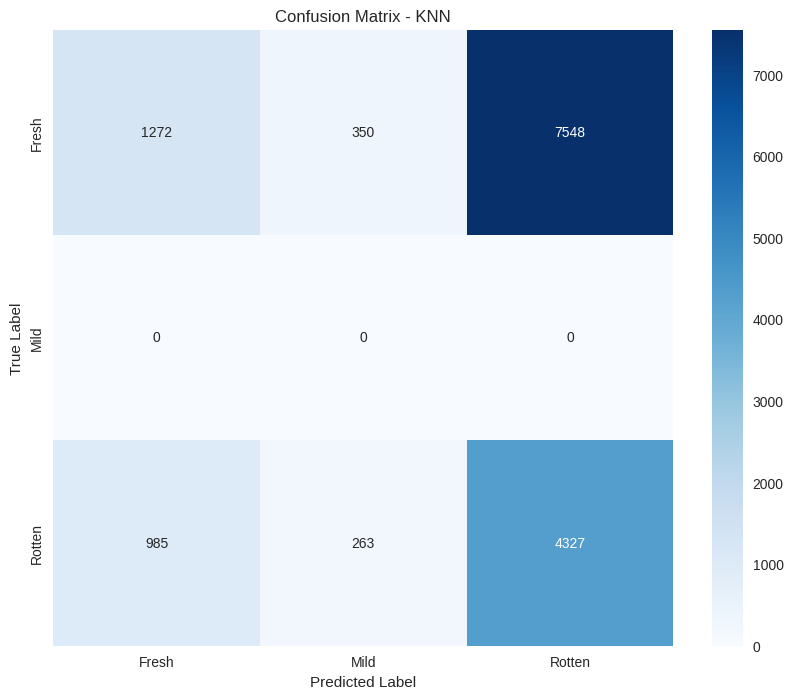


Evaluating KNN on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.213
Mild/Mixed: 0.150
Rotten/Bad: 0.637

Prediction distribution for mixed quality fruits:
Good/Fresh: 240 (22.3%)
Mild/Mixed: 158 (14.7%)
Rotten/Bad: 676 (62.9%)

Average prediction entropy: 0.099

Training SVM...
Evaluating SVM on clear quality data...

SVM Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.85      0.44      0.58      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.52      0.80      0.63      5575

    accuracy                           0.58     14745
   macro avg       0.46      0.41      0.40     14745
weighted avg       0.72      0.58      0.60     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


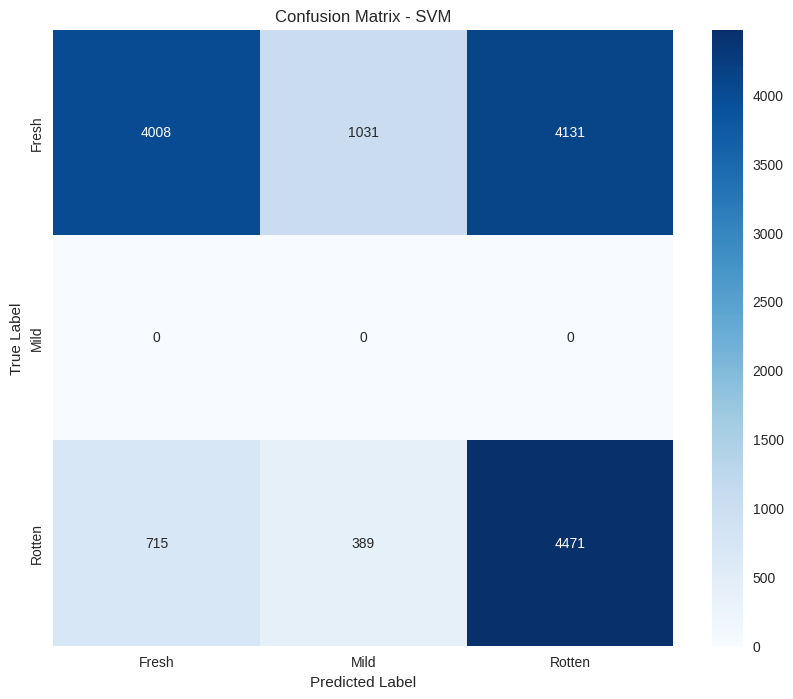


Evaluating SVM on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.655
Mild/Mixed: 0.067
Rotten/Bad: 0.278

Prediction distribution for mixed quality fruits:
Good/Fresh: 739 (68.8%)
Mild/Mixed: 32 (3.0%)
Rotten/Bad: 303 (28.2%)

Average prediction entropy: 0.319

Training Random Forest...
Evaluating Random Forest on clear quality data...

Random Forest Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.69      0.04      0.08      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.43      0.92      0.58      5575

    accuracy                           0.37     14745
   macro avg       0.37      0.32      0.22     14745
weighted avg       0.59      0.37      0.27     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


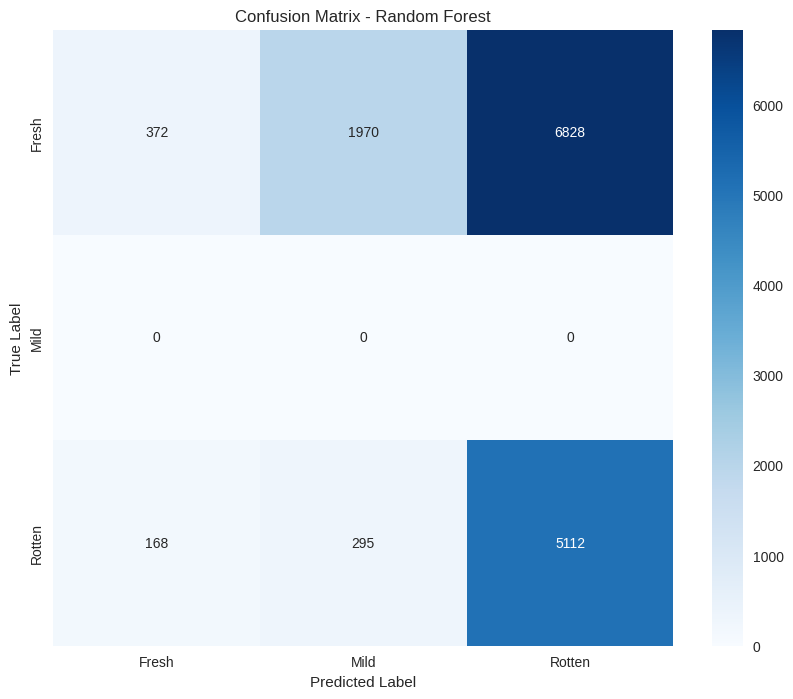


Evaluating Random Forest on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.289
Mild/Mixed: 0.347
Rotten/Bad: 0.364

Prediction distribution for mixed quality fruits:
Good/Fresh: 41 (3.8%)
Mild/Mixed: 569 (53.0%)
Rotten/Bad: 464 (43.2%)

Average prediction entropy: 1.518

Training Neural Network...
Evaluating Neural Network on clear quality data...

Neural Network Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.87      0.46      0.60      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.52      0.81      0.63      5575

    accuracy                           0.59     14745
   macro avg       0.46      0.42      0.41     14745
weighted avg       0.73      0.59      0.61     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


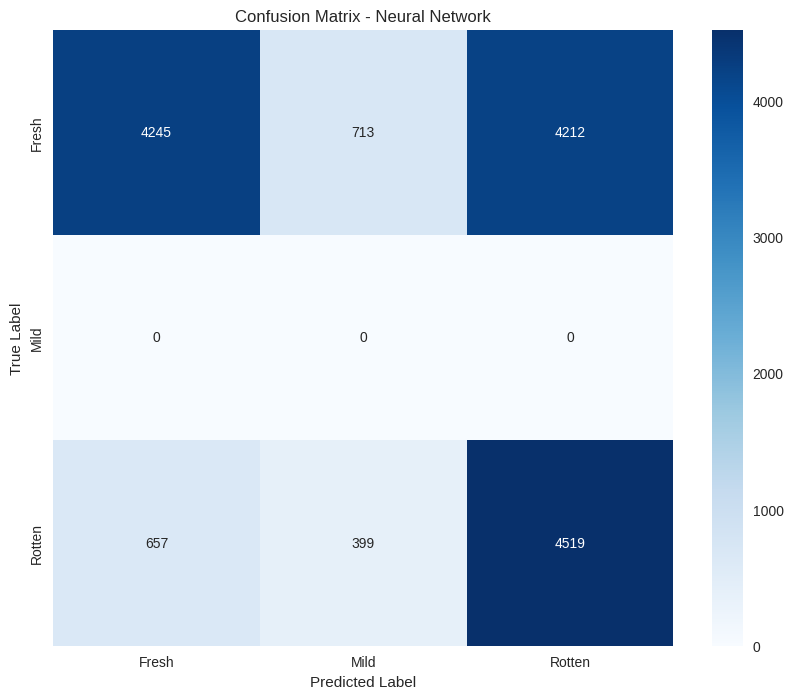


Evaluating Neural Network on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.295
Mild/Mixed: 0.273
Rotten/Bad: 0.432

Prediction distribution for mixed quality fruits:
Good/Fresh: 318 (29.6%)
Mild/Mixed: 291 (27.1%)
Rotten/Bad: 465 (43.3%)

Average prediction entropy: 0.116

Training Decision Tree...
Evaluating Decision Tree on clear quality data...

Decision Tree Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.74      0.49      0.59      9170
        Mild       0.00      0.00      0.00         0
      Rotten       0.56      0.60      0.58      5575

    accuracy                           0.53     14745
   macro avg       0.43      0.36      0.39     14745
weighted avg       0.67      0.53      0.59     14745



/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeff/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


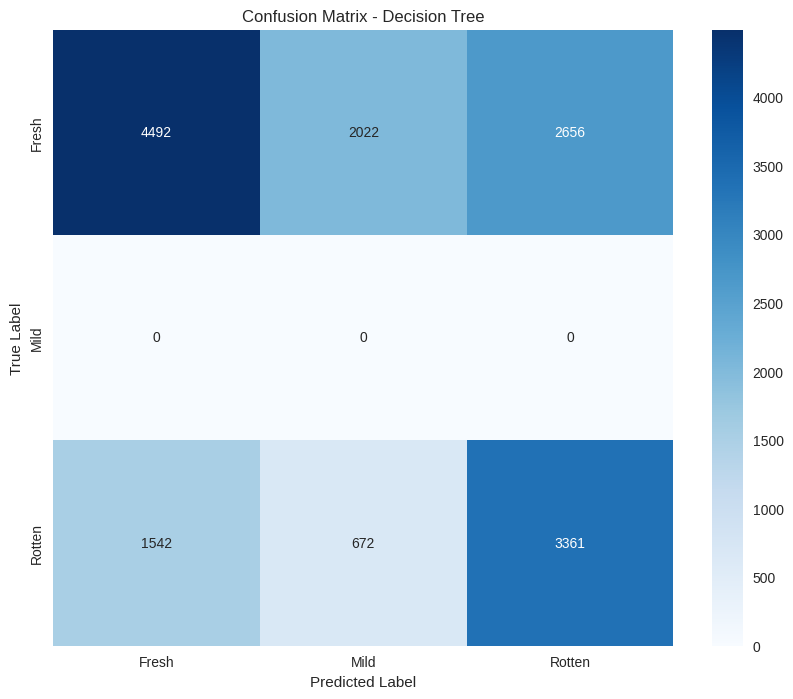


Evaluating Decision Tree on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.466
Mild/Mixed: 0.358
Rotten/Bad: 0.175

Prediction distribution for mixed quality fruits:
Good/Fresh: 501 (46.6%)
Mild/Mixed: 385 (35.8%)
Rotten/Bad: 188 (17.5%)

Average prediction entropy: -0.000

=== Scenario 2: Combined Dataset Evaluation ===

Training KNN on combined dataset...
Evaluating KNN...

KNN Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.99      0.97      0.98      2271
        Mild       0.99      1.00      0.99       273
      Rotten       0.96      0.99      0.97      1535

    accuracy                           0.98      4079
   macro avg       0.98      0.98      0.98      4079
weighted avg       0.98      0.98      0.98      4079



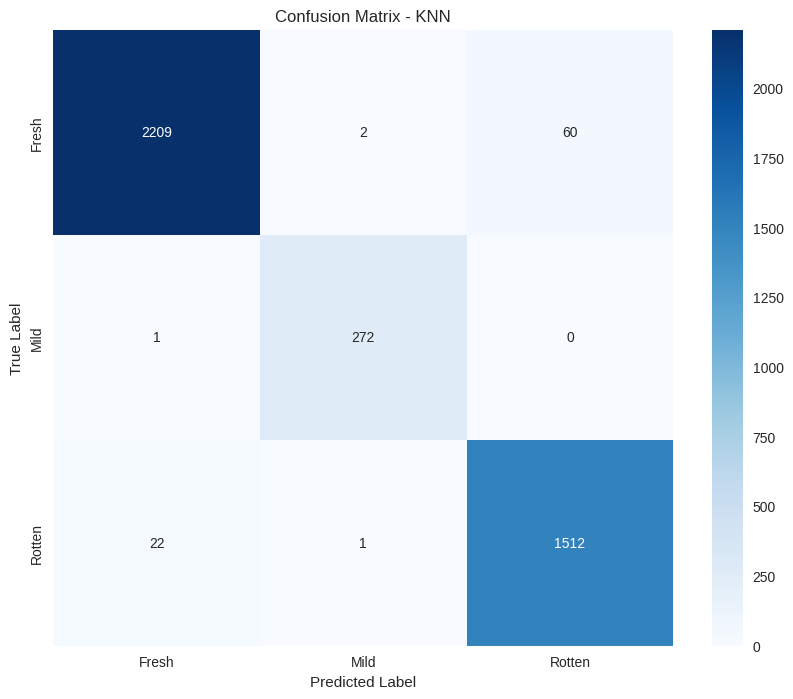


Evaluating KNN on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.754
Mild/Mixed: 0.000
Rotten/Bad: 0.246

Prediction distribution for mixed quality fruits:
Good/Fresh: 828 (77.1%)
Rotten/Bad: 246 (22.9%)

Average prediction entropy: 0.326

Training SVM on combined dataset...
Evaluating SVM...

SVM Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.96      0.96      0.96      2271
        Mild       0.93      0.80      0.86       273
      Rotten       0.96      0.97      0.97      1535

    accuracy                           0.96      4079
   macro avg       0.95      0.91      0.93      4079
weighted avg       0.96      0.96      0.96      4079



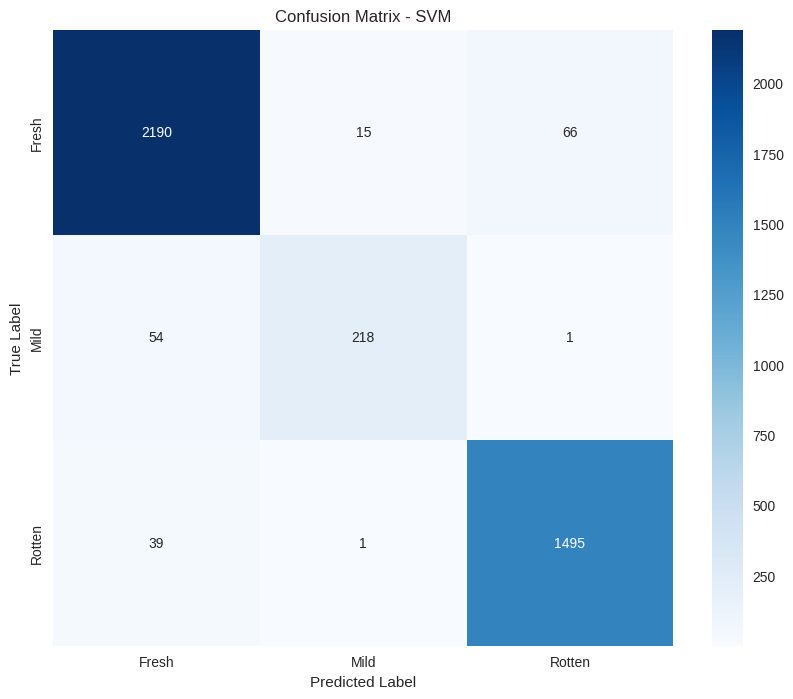


Evaluating SVM on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.845
Mild/Mixed: 0.002
Rotten/Bad: 0.153

Prediction distribution for mixed quality fruits:
Good/Fresh: 915 (85.2%)
Rotten/Bad: 159 (14.8%)

Average prediction entropy: 0.354

Training Random Forest on combined dataset...
Evaluating Random Forest...

Random Forest Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.99      0.98      0.99      2271
        Mild       1.00      0.99      1.00       273
      Rotten       0.98      0.99      0.98      1535

    accuracy                           0.99      4079
   macro avg       0.99      0.99      0.99      4079
weighted avg       0.99      0.99      0.99      4079



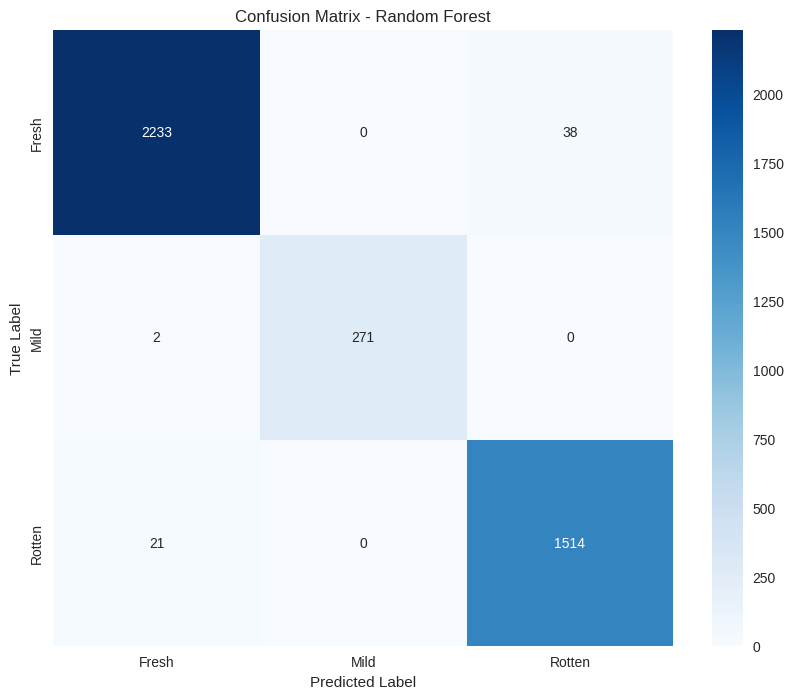


Evaluating Random Forest on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.759
Mild/Mixed: 0.002
Rotten/Bad: 0.239

Prediction distribution for mixed quality fruits:
Good/Fresh: 958 (89.2%)
Rotten/Bad: 116 (10.8%)

Average prediction entropy: 0.657

Training Neural Network on combined dataset...
Evaluating Neural Network...

Neural Network Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      0.98      0.99      2271
        Mild       0.99      1.00      0.99       273
      Rotten       0.97      0.99      0.98      1535

    accuracy                           0.99      4079
   macro avg       0.99      0.99      0.99      4079
weighted avg       0.99      0.99      0.99      4079



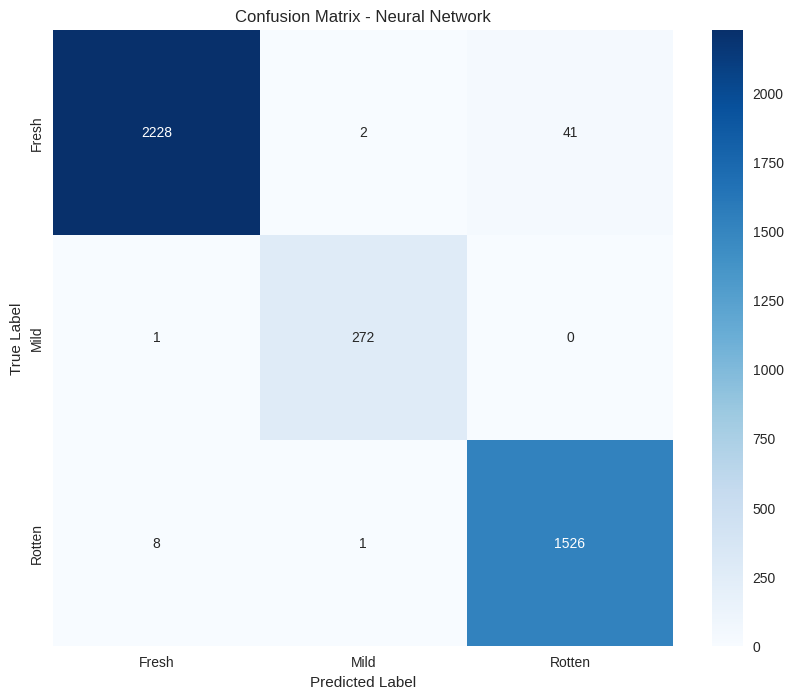


Evaluating Neural Network on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.740
Mild/Mixed: 0.000
Rotten/Bad: 0.260

Prediction distribution for mixed quality fruits:
Good/Fresh: 805 (75.0%)
Rotten/Bad: 269 (25.0%)

Average prediction entropy: 0.217

Training Decision Tree on combined dataset...
Evaluating Decision Tree...

Decision Tree Performance:

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.97      0.97      0.97      2271
        Mild       0.99      1.00      0.99       273
      Rotten       0.96      0.96      0.96      1535

    accuracy                           0.97      4079
   macro avg       0.98      0.98      0.98      4079
weighted avg       0.97      0.97      0.97      4079



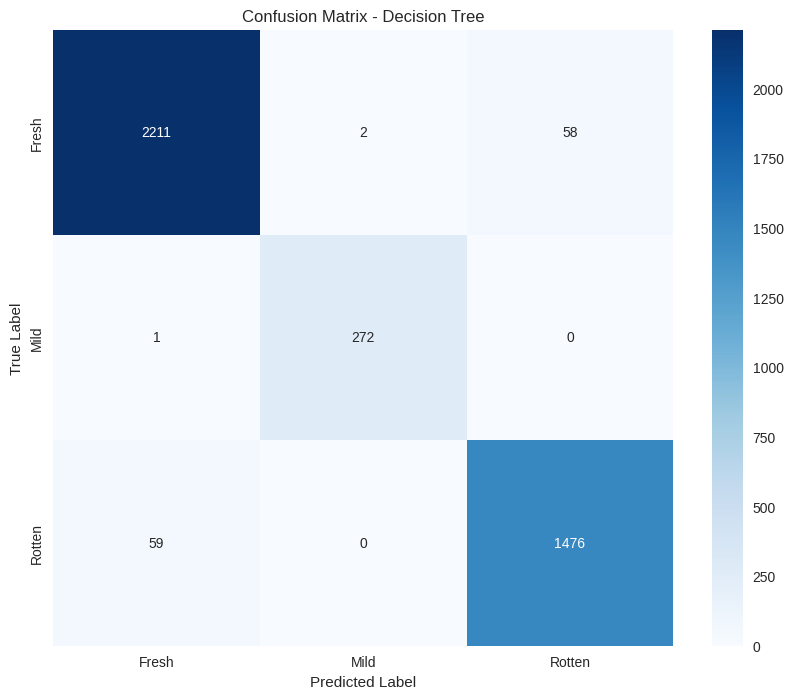


Evaluating Decision Tree on mixed quality data...

Average probability distribution for mixed quality fruits:
Good/Fresh: 0.805
Mild/Mixed: 0.000
Rotten/Bad: 0.195

Prediction distribution for mixed quality fruits:
Good/Fresh: 865 (80.5%)
Rotten/Bad: 209 (19.5%)

Average prediction entropy: -0.000


In [17]:
class CrossDatasetEvaluator:
    def __init__(self):
        self.loader = FruitQualityDataLoader()
        self.extractor = FruitFeatureExtractor()
        self.evaluator = ModelEvaluator()
        self.classifiers = {
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'SVM': SVC(kernel='rbf', probability=True),
            'Random Forest': RandomForestClassifier(n_estimators=100),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50)),
            'Decision Tree': DecisionTreeClassifier()
        }
        
    def load_and_prepare_datasets(self, zenodo_path, kaggle_path):
        """Load and prepare both datasets separately"""
        print("Loading Zenodo dataset...")
        zenodo_paths, zenodo_labels = self.loader.load_zenodo_dataset(zenodo_path, subset="FruQ-DB")
        
        print("\nLoading Kaggle dataset...")
        kaggle_paths, kaggle_labels = self.loader.load_kaggle_dataset(kaggle_path)
        
        # Create separate test sets for clear quality and mixed quality
        kaggle_clear_mask = kaggle_labels != 1  # Exclude mixed quality
        kaggle_mixed_mask = kaggle_labels == 1  # Only mixed quality
        
        kaggle_clear_paths = [p for p, m in zip(kaggle_paths, kaggle_clear_mask) if m]
        kaggle_clear_labels = kaggle_labels[kaggle_clear_mask]
        
        kaggle_mixed_paths = [p for p, m in zip(kaggle_paths, kaggle_mixed_mask) if m]
        kaggle_mixed_labels = kaggle_labels[kaggle_mixed_mask]
        
        # Extract features
        print("\nExtracting features...")
        print("Zenodo dataset...")
        X_zenodo = self.extractor.prepare_dataset(zenodo_paths, fit_scaler=True)
        
        print("Kaggle clear quality dataset...")
        X_kaggle_clear = self.extractor.prepare_dataset(kaggle_clear_paths, fit_scaler=False)
        
        print("Kaggle mixed quality dataset...")
        X_kaggle_mixed = self.extractor.prepare_dataset(kaggle_mixed_paths, fit_scaler=False)
        
        return {
            'zenodo': (X_zenodo, zenodo_labels),
            'kaggle_clear': (X_kaggle_clear, kaggle_clear_labels),
            'kaggle_mixed': (X_kaggle_mixed, kaggle_mixed_labels)
        }
    
    def evaluate_mixed_quality(self, model, X_mixed, mixed_labels):
        """Special evaluation for mixed quality fruits"""
        # Get probability predictions for each class
        probabilities = model.predict_proba(X_mixed)
        
        # Calculate average probability distribution
        avg_probs = np.mean(probabilities, axis=0)
        print("\nAverage probability distribution for mixed quality fruits:")
        for label, prob in zip(self.loader.quality_labels, avg_probs):
            print(f"{label}: {prob:.3f}")
        
        # Analyze prediction distribution
        predictions = model.predict(X_mixed)
        unique, counts = np.unique(predictions, return_counts=True)
        print("\nPrediction distribution for mixed quality fruits:")
        for label, count in zip(unique, counts):
            percentage = (count / len(predictions)) * 100
            print(f"{self.loader.quality_labels[label]}: {count} ({percentage:.1f}%)")
            
        # Calculate uncertainty metrics
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10), axis=1)
        print(f"\nAverage prediction entropy: {np.mean(entropy):.3f}")
    
    def run_evaluation_scenarios(self, zenodo_path, kaggle_path):
        """Run all evaluation scenarios"""
        # Load and prepare all datasets
        datasets = self.load_and_prepare_datasets(zenodo_path, kaggle_path)
        
        # Scenario 1: Train on Zenodo, test on Kaggle clear quality
        print("\n=== Scenario 1: Train on Zenodo, Test on Kaggle (Clear Quality) ===")
        X_train, y_train = datasets['zenodo']
        X_test, y_test = datasets['kaggle_clear']
        
        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")
            clf.fit(X_train, y_train)
            
            print(f"Evaluating {name} on clear quality data...")
            predictions = clf.predict(X_test)
            self.evaluator.evaluate_model(y_test, predictions, name)
            
            print(f"\nEvaluating {name} on mixed quality data...")
            X_mixed, y_mixed = datasets['kaggle_mixed']
            self.evaluate_mixed_quality(clf, X_mixed, y_mixed)
        
        # Scenario 2: Combined dataset evaluation
        print("\n=== Scenario 2: Combined Dataset Evaluation ===")
        # Combine Zenodo and Kaggle clear quality data
        X_combined = np.vstack([datasets['zenodo'][0], datasets['kaggle_clear'][0]])
        y_combined = np.concatenate([datasets['zenodo'][1], datasets['kaggle_clear'][1]])
        
        # Split combined dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
        )
        
        for name, clf in self.classifiers.items():
            print(f"\nTraining {name} on combined dataset...")
            clf.fit(X_train, y_train)
            
            print(f"Evaluating {name}...")
            predictions = clf.predict(X_test)
            self.evaluator.evaluate_model(y_test, predictions, name)
            
            print(f"\nEvaluating {name} on mixed quality data...")
            X_mixed, y_mixed = datasets['kaggle_mixed']
            self.evaluate_mixed_quality(clf, X_mixed, y_mixed)



In [ ]:
evaluator = CrossDatasetEvaluator()
evaluator.run_evaluation_scenarios(
    zenodo_path='fruit_datasets/zenodo_data',
    kaggle_path='fruit_datasets/kaggle_data'
)